# OpenSearch Serverless 벡터서치 Collection 및 Amazon Bedrock를 사용한 RAG 
> 이 노트북은  SageMaker Studio* **`Data Science 3.0`** kernel 및 ml.t3.medium 인스턴스에서 테스트 되었습니다.
---
### 중요
- 이 노트북은 Anthropic 의 Claude-v2 모델 접근 가능한 분만 실행 가능합니다. 
- 접근이 안되시는 분은 노트북의 코드와 결과 만을 확인 하시면 좋겠습니다.
- 만일 실행시에는 **"과금"** 이 발생이 되는 부분 유념 해주시기 바랍니다.

### 선수조건
- 임베딩 모델의 세이지 메이커 엔드포인트가 액티브 된 상태를 가정 합니다.
    - 세이지 메이커 엔드포인트에 배포하기 위해서는 아래 노트북을 실행하시고, Endpoint Name 만을 복사 하시면 됩니다.
    - [KoSIMCSERoberta Embedding Model 배포](https://github.com/gonsoomoon-ml/Kor-LLM-On-SageMaker/blob/main/1-Lab01-Deploy-LLM/4.Kor-Embedding-Model.ipynb)
    - SageMaker Endpoint 에 대해서는 공식 개발자 문서를 참조하세요 --> [Create your endpoint and deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deployment.html)
- 오픈 서치 서비스가 액티브 된 상태를 가정 합니다.
---

OpenSearch Serverless는 대규모 데이터셋에 대한 유사도 검색을 위한 강력한 엔진인 OpenSearch의 Serverless 서비스입니다. Amazon OpenSearch Serverless를 통해 클라우드 환경에서 미리 프로비저닝 된 리소스를 빠르게 이용할 수 있습니다. 이와 함께 Vector Store를 사용하면 고차원 벡터 데이터를 효율적으로 저장하고 빠르게 검색할 수 있어, 복잡한 자연어 처리 작업을 더욱 간편하게 수행할 수 있습니다.


In [ ]:
!pip install -r requirements.txt

In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
module_path = ".."
sys.path.append(os.path.abspath(module_path))

# 1. Bedrock Client 생성

In [ ]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
# os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."


boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print(colored("\n== FM lists ==", "green"))
pprint(bedrock_info.get_list_fm_models(verbose=True))

# 2. Titan Embedding 및 LLM 인 Claude-v2 모델 로딩

## LLM 로딩 (Claude-v2-1)

In [ ]:
import langchain
from langchain.llms.bedrock import Bedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [ ]:
# - create the Anthropic Model
llm_text = Bedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V2-1"),
    client=boto3_bedrock,
    model_kwargs={
        "max_tokens_to_sample": 512
    },
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)
llm_text

## Embedding 모델 선택

In [ ]:
from utils.rag import KoSimCSERobertaContentHandler, SagemakerEndpointEmbeddingsJumpStart

def get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name=None):
    if is_bedrock_embeddings:

        # We will be using the Titan Embeddings Model to generate our Embeddings.
        from langchain.embeddings import BedrockEmbeddings

        llm_emb = BedrockEmbeddings(
            client=boto3_bedrock,
            model_id=bedrock_info.get_model_id(
                model_name="Titan-Embeddings-G1"
            )
        )

        print("Bedrock Embeddings Model Loaded")
        
    elif is_KoSimCSERobert:
        LLMEmbHandler = KoSimCSERobertaContentHandler()
        endpoint_name_emb = endpont_name
        llm_emb = SagemakerEndpointEmbeddingsJumpStart(
            endpoint_name=endpoint_name_emb,
            region_name=aws_region,
            content_handler=LLMEmbHandler,
        )        
        print("KoSimCSERobert Embeddings Model Loaded")
    else:
        llm_emb = None
        print("No Embedding Model Selected")
    
    return llm_emb

#### [중요] is_KoSimCSERobert == True 일시에 endpoint_name 을 꼭 넣어 주세요.

In [ ]:
is_bedrock_embeddings = True
is_KoSimCSERobert = False

aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

##############################
# Parameters for is_KoSimCSERobert
##############################
if is_KoSimCSERobert: endpont_name = "<endpoint-name>"
else: endpont_name = None
##############################

llm_emb = get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name)     

In [ ]:
print(llm_emb)

# 3. 데이터 준비


##  신한은행 FAQ 데이터 세트로 구현
- [중요] 저자 및 동료가 아래의 웹사이트에서 크로링한 기준으로 구성 하였습니다.
- 인터넷뱅킹 FAQ > 스마트뱅킹 No.1 ~ N. 89 로 구성되었습니다. 
- https://www.shinhan.com/hpe/index.jsp#050101020000

In [ ]:
import pandas as pd
pd.options.display.max_rows = 20

data_file_path = "data/fsi_smart_faq_ko.csv"
df = pd.read_csv(data_file_path)
df

### CSVLoader 로 문서 로딩

In [ ]:
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import FAISS
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

In [ ]:
loader = CSVLoader(
    file_path="data/fsi_smart_faq_ko_preprocess.csv",
    # csv_args={
    #     "delimiter": ",",
    #     "fieldnames": ["Category", "Information", "type", "Source"],
    # },    
    source_column="Source",
    encoding="utf-8"
)


## 메타 데이터 생성
- 기존 Category 컬럼을 ask 로 변경 합니다.
- 컬럼의 type, source 는 metadata 로 생성하고, 내용에서는 삭제 합니다.
- 타임스탬프 및 임베딩 모델의 엔드포인트 이름을 metadata 로 추가 합니다.

In [ ]:
import time
documents_fsi = loader.load()

def create_metadata(docs):
    # # add a custom metadata field, such as timestamp
    for idx, doc in enumerate(docs):
        # type 을 메타 데이타로 저장
        stype = doc.page_content.split("type: ")[1].split("\n")[0]
        # print("stype: ", stype)
        split_content = doc.page_content.split("type: ")
        content = split_content[0]        
        metadata = split_content[1]                
        doc.metadata['type'] = metadata.split("\n")[0]        
        doc.page_content = content # metadata 제외하고 content 만 저장
        # doc.metadata['type'] = doc.page_content.split("type: ")[1].split("\n")[0]
        doc.metadata['timestamp'] = time.time()

        
create_metadata(documents_fsi)

In [ ]:
print(len(documents_fsi))

documents_fsi[0]
# documents_fsi[-1]

## Text Spliter 로 청킹
참고: 검색된 문서/텍스트는 질문에 대답하기에 충분한 정보를 포함할 만큼 커야 합니다. 하지만 LLM 프롬프트에 들어갈 만큼 충분히 작습니다. 또한 임베딩 모델에는 입력 토큰 길이가 512개 토큰으로 제한되어 있으며 이는 한국어의 경우에 대략 180 ~ 200 글자로 변환됩니다. 이 사용 사례를 위해 [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html)를 사용하여 210자가 겹치는 약 50자의 청크를 생성합니다.

In [ ]:
if is_bedrock_embeddings:
    chunk_size = 2048
    chunk_overlap = 0
elif is_KoSimCSERobert:
    chunk_size = 800 # This is maxumum
    chunk_overlap = 0
    

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
    separators=["\n\n", "\n", ".", " ", ""],
    length_function = len,
)

docs = text_splitter.split_documents(documents_fsi)
print(f"Number of documents after split and chunking={len(docs)}")

## 청킹 통계 및 내용 확인

In [ ]:
from utils.rag import show_context_used, show_chunk_stat
    
show_chunk_stat(docs)

# 4. OpenSearch 벡터 Indexer 생성
- 랭체인 오프서치 참고 자료
    - [Langchain Opensearch](https://python.langchain.com/docs/integrations/vectorstores/opensearch)

In [ ]:
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from langchain.vectorstores import OpenSearchVectorSearch

In [ ]:
import boto3
import json
from sagemaker import get_execution_role

def get_notebook_name():
    with open('/opt/ml/metadata/resource-metadata.json') as f:
        data = json.load(f)
    return data['ResourceName']

role_arn = get_execution_role()
print(role_arn)
# notebook_name = get_notebook_name()
# sm_client = boto3.client('sagemaker')
# response = sm_client.describe_notebook_instance(NotebookInstanceName=notebook_name)
# print(response)
# # role_arn = response['RoleArn']



# # print(f"Notebook Instance Role ARN: {role_arn}")

## SageMaker Notebook role에 권한 부여
> SageMaker notebook roles에 OpenSearch Serverless Collection 및 Policy를 생성할 수 있는 권한을 부여하기 위해 하례 단계를 수행합니다. 다음은 콘솔의 Admin 권한을 가지고 있는 역할이 수행할 수 있습니다.

위에서 수행한 결과인 role의 Execution Policy 권한 정책에 다음 코드를 붙여넣어줍니다.
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:DeleteObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::*"
            ]
        },
        {
            "Sid": "Statement1",
            "Effect": "Allow",
            "Action": [
                "aoss:CreateSecurityPolicy",
                "aoss:CreateCollection",
                "aoss:ListCollections",
                "aoss:BatchGetCollection",
                "aoss:DeleteCollection",
                "aoss:UpdateCollection",
                "aoss:CreateAccessPolicy",
                "aoss:ListAccessPolicies",
                "aoss:UpdateAccessPolicy",
                "iam:ListUsers",
                "iam:ListRoles",
                "aoss:APIAccessAll",
                "aoss:DashboardsAccessAll",
                "aoss:GetAccessPolicy"
            ],
            "Resource": [
                "*"
            ]
        }
    ]
}
```


# 5. OpenSearch Serverless 생성
- 오프서치 서버리스 참고 자료
    - [Getting started with Amazon OpenSearch Serverless](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/serverless-getting-started.html)

In [ ]:
import boto3
import json

client = boto3.client('opensearchserverless')
collection_name = "demo-korean-vectorsearch"  # Make sure this is correct

policy = [
    {
    "Rules": [
        {
            "ResourceType": "collection",
            "Resource": [
                "collection/*"
            ],
            "Permission": [
                "aoss:CreateCollectionItems", 
                "aoss:DeleteCollectionItems", 
                "aoss:UpdateCollectionItems", 
                "aoss:DescribeCollectionItems", 
                "aoss:*"
            ]
        },
        {
        "Resource": [
          "index/demo-korean-vectorsearch/*"
        ],
        "Permission": [
          "aoss:CreateIndex",
          "aoss:DeleteIndex",
          "aoss:UpdateIndex",
          "aoss:DescribeIndex",
          "aoss:ReadDocument",
          "aoss:WriteDocument"
        ],
        "ResourceType": "index"
      }
    ],
    "Principal": [
        f"{role_arn}",  # This allows any role in your account. Adjust as needed.
        ]
    }
]

try:
    response = client.create_access_policy(
        name=f"{collection_name}-policy",
        type='data',
        policy=json.dumps(policy)
    )
    print("Access policy created successfully:")
    print(json.dumps(response, indent=2))
except Exception as e:
    print(f"Error creating access policy: {str(e)}")

In [ ]:
import boto3
import json

client = boto3.client('opensearchserverless')

# Define the network policy
policy = [
    {
    "Rules": [
        {
            "ResourceType": "collection",
            "Resource": [
                "collection/demo-korean-vectorsearch"
            ]
        },
        {
            "ResourceType": "dashboard",
            "Resource": [
                "collection/demo-korean-vectorsearch"
            ]
        }
    ],
    "AllowFromPublic": True  # This allows public access. Set to False if you want to restrict access.
    }
]

# Create the policy
try:
    response = client.create_security_policy(
        name="demo-network-policy",
        policy=json.dumps(policy),
        type="network",
        description="Network policy for demo-korean-vectorsearch"
    )
    print("Network policy created successfully:")
    print(json.dumps(response, indent=2))
except Exception as e:
    print(f"Error creating network policy: {str(e)}")

In [ ]:
# Create the policy
try:
    response = client.create_security_policy(
        name="demo-security-policy",
        policy="""
                {
                    \"Rules\":[
                        {
                            \"ResourceType\":\"collection\",
                            \"Resource\":[
                                \"collection\/demo-korean-vectorsearch\"
                            ]
                        }
                    ],
                    \"AWSOwnedKey\":true
                }
                """,
        type='encryption',
        description='Encryption policy for demo collections',
    )
    print("Access policy created successfully:")
    print(json.dumps(response, indent=2))
except Exception as e:
    print(f"Error creating access policy: {str(e)}")

### VectorSearch Collection 생성

In [ ]:
client = boto3.client('opensearchserverless')
service = 'aoss'
region = 'us-east-1'
credentials = boto3.Session().get_credentials()
new_auth = AWSV4SignerAuth(credentials, region, service)


response = client.create_collection(
            name='demo-korean-vectorsearch',
            type='VECTORSEARCH'
        )
print(response)

### 생성한 Collection 확인
> Collection이 생성되는 동안 10-20초 정도 기다린 뒤에 다음 셀을 실행해주세요.

In [ ]:
client = boto3.client('opensearchserverless')
collection_name = "demo-korean-vectorsearch"  # Make sure this is correct

try:
    response = client.batch_get_collection(names=[collection_name])
    host = (response['collectionDetails'][0]['collectionEndpoint'])
    vector_host = host.replace("https://", "")
    print(vector_host)
except Exception as e:
    print(f"Error getting collection details: {str(e)}")

## Opensearch data access policy에 admin 권한 추가

### console 화면에서 데이터를 확인하기 위해 admin role을 추가
- data access policy 혹은 액세스 정책 설정 탭에서 아래 화살표처럼 미리 만들어둔 **`demo-korean-vectorsearch-policy`** 를 클릭합니다.

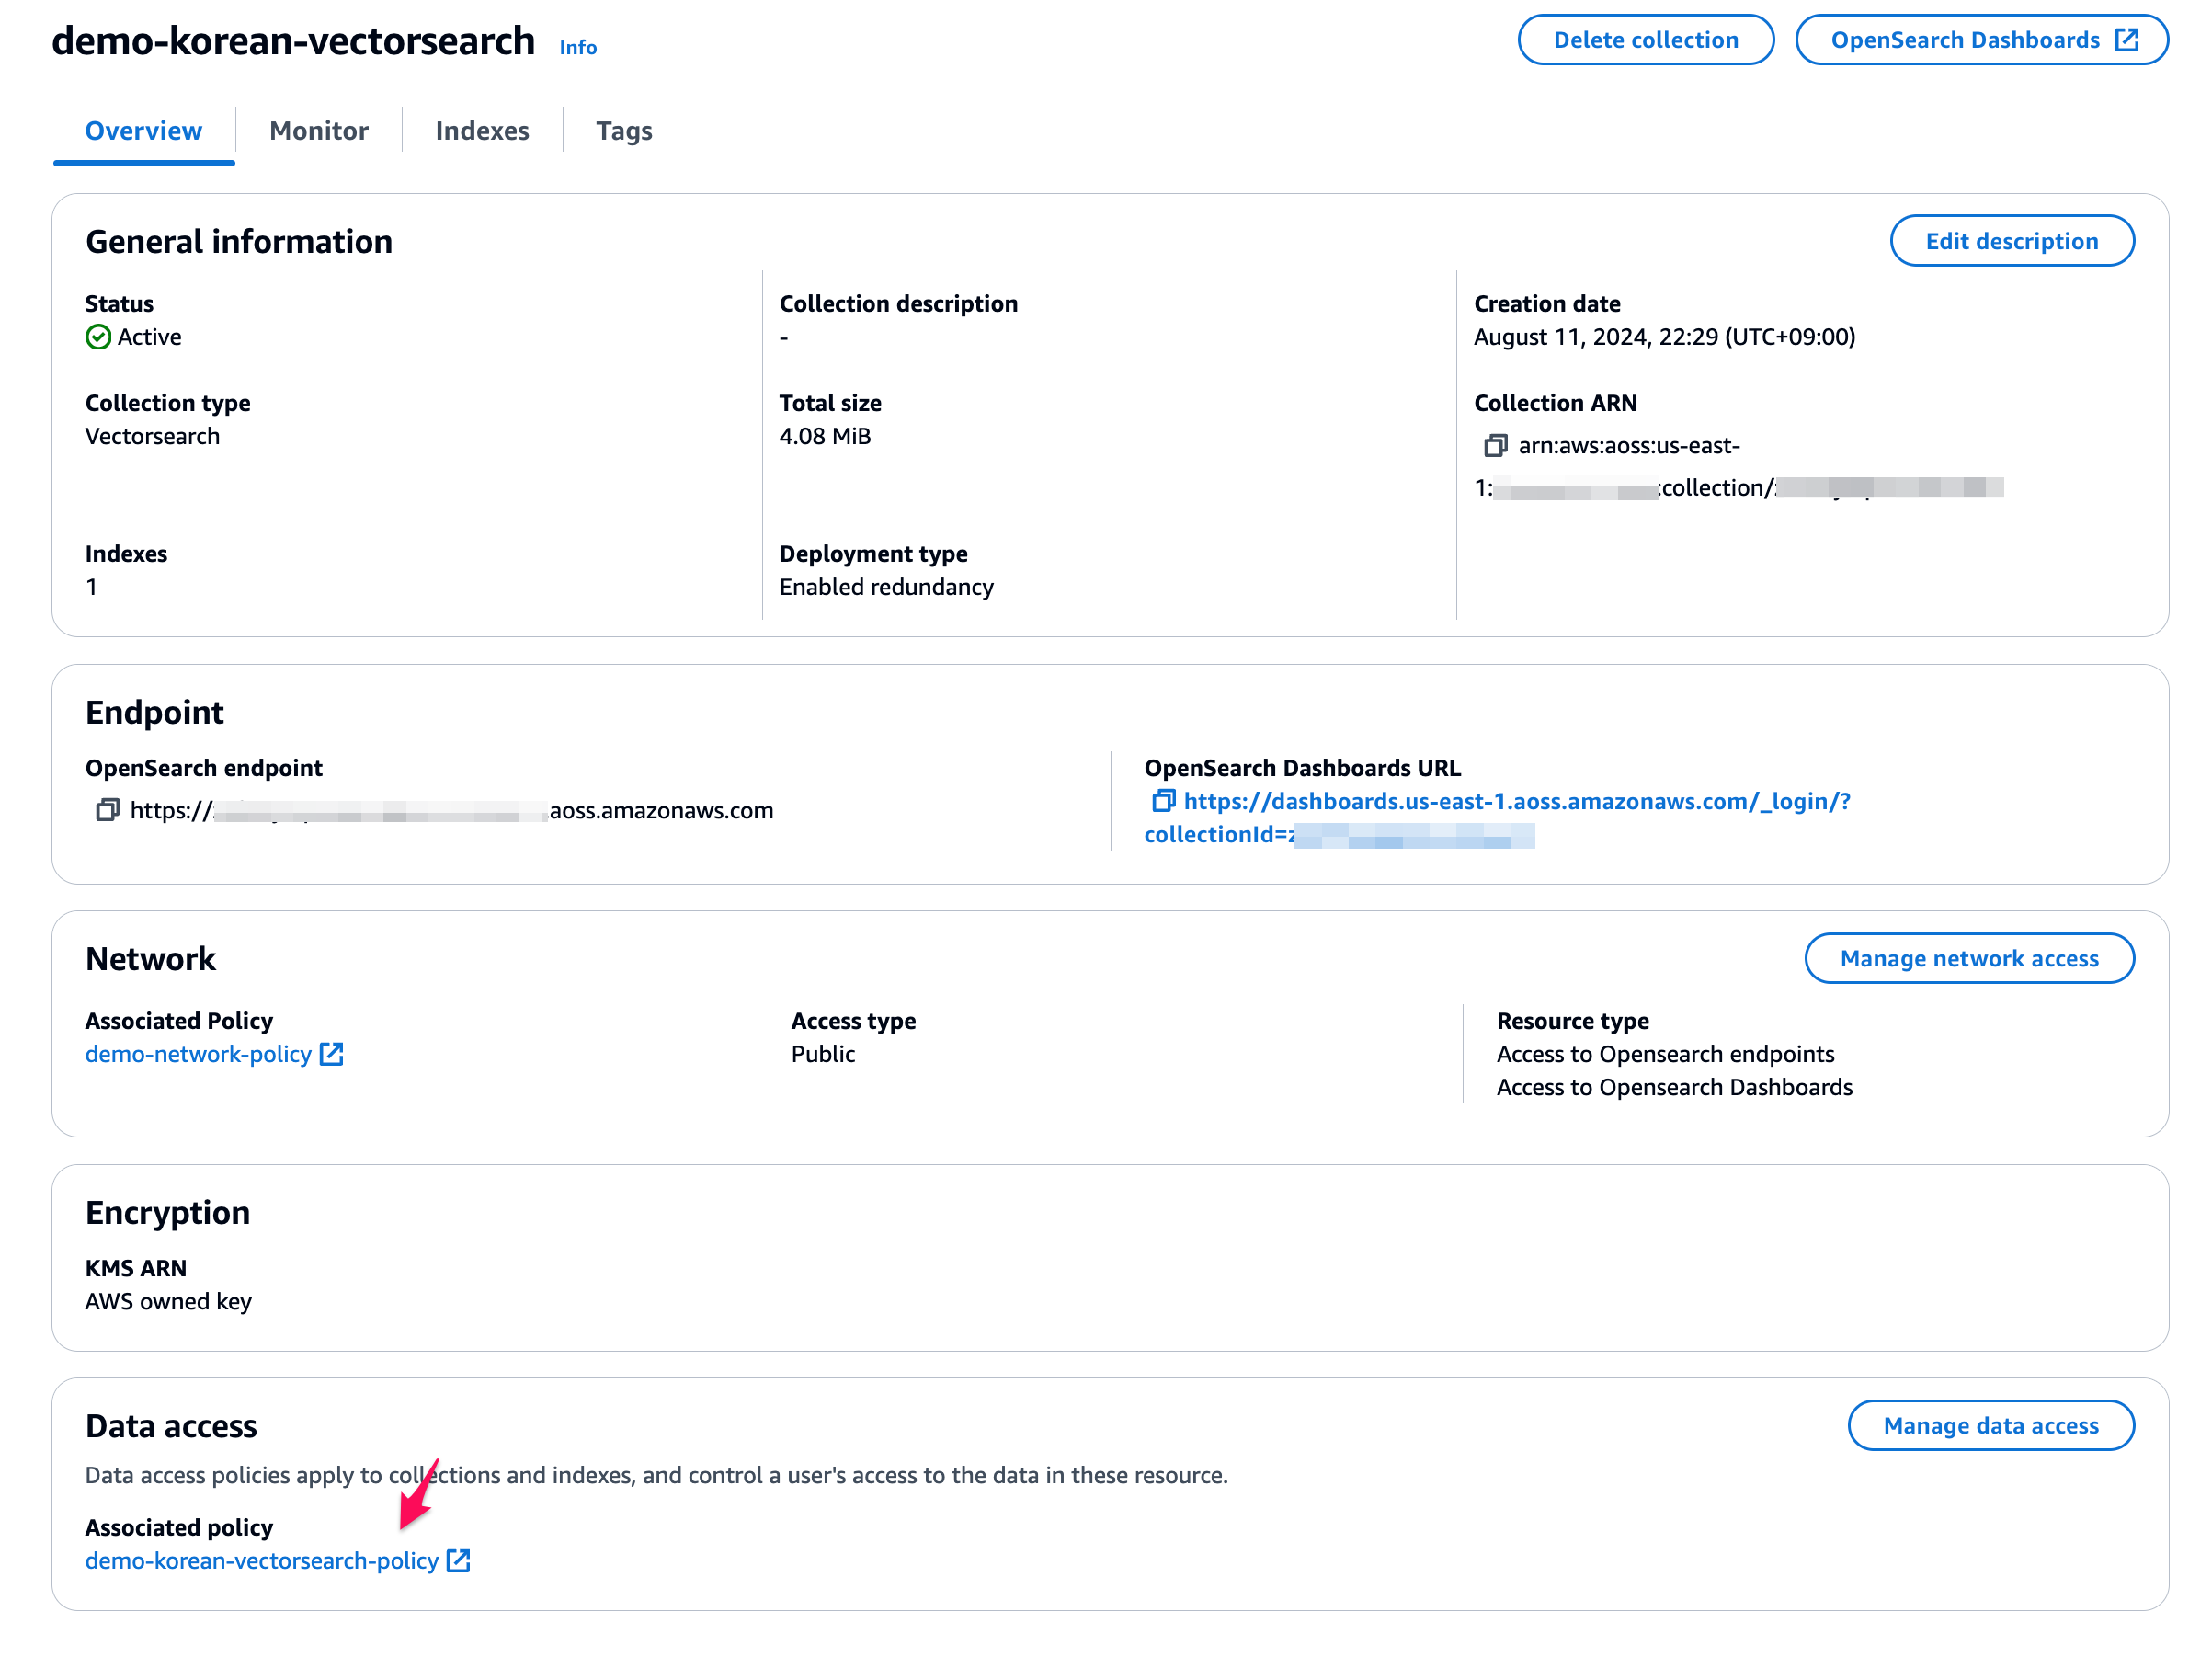

- 그 다음 Edit 버튼을 눌러 수정 페이지에 접근합니다.

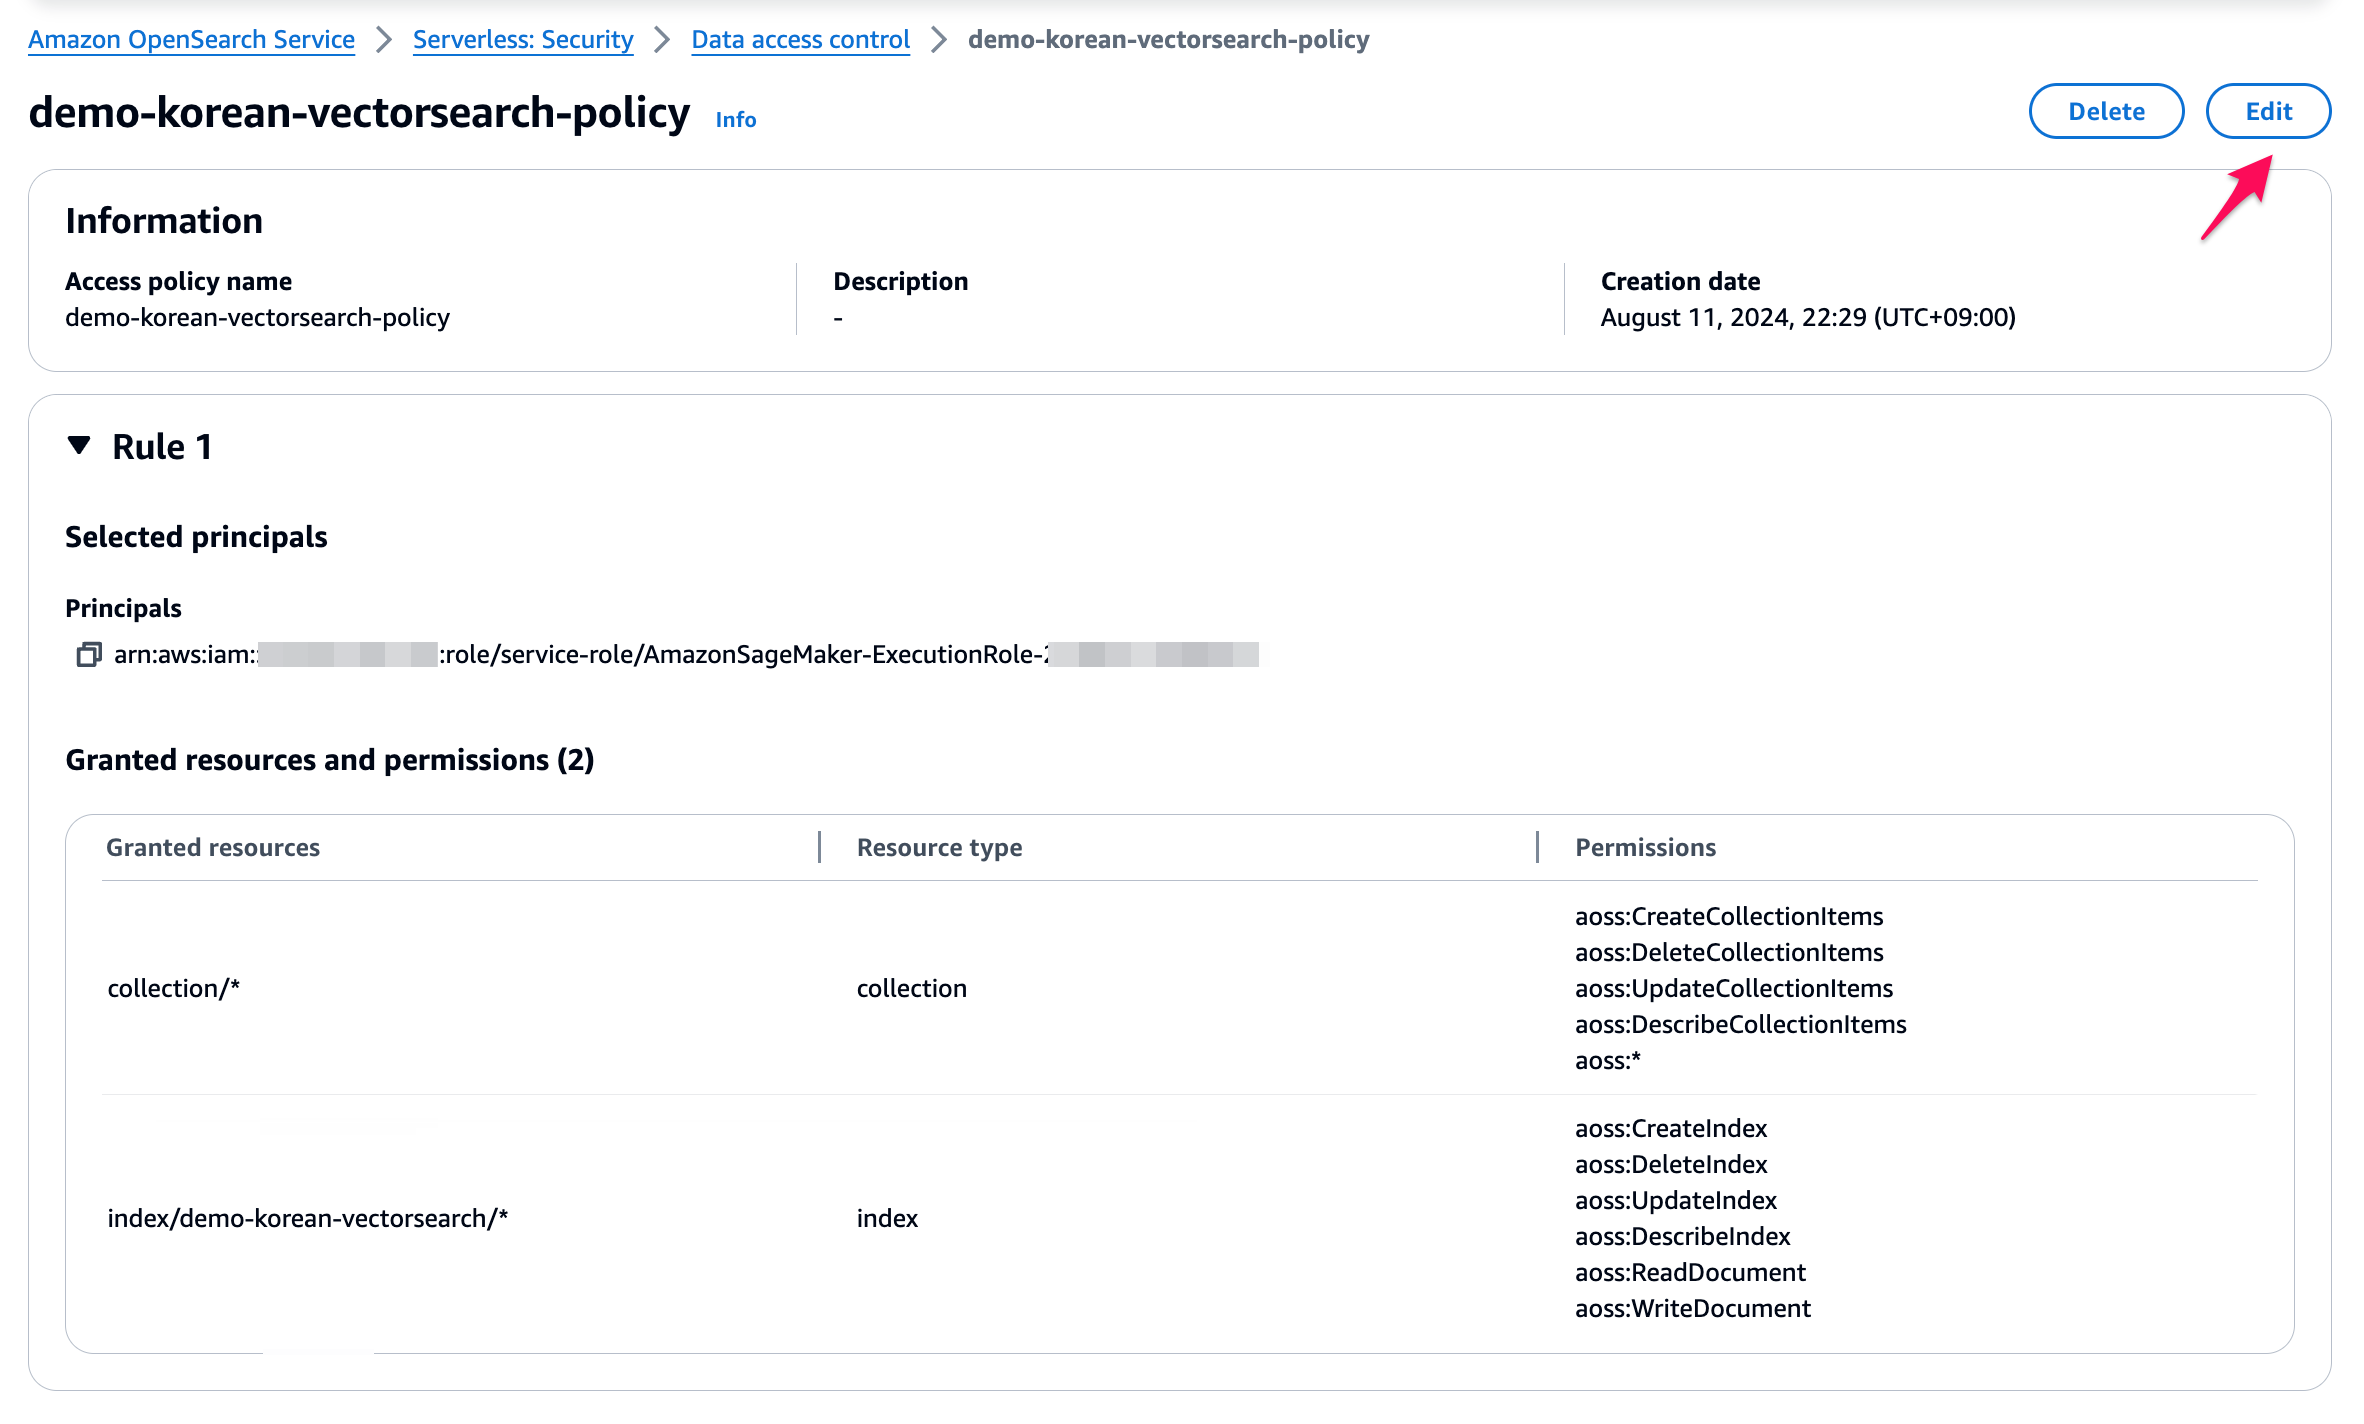

- 아래 사진처럼 **`Add principals`** -> **`IAM users and roles`** 를 선택한 뒤
- **`arn:aws:iam::현재 사용중인 계정 12자리:role/Admin`** 을 입력해주고 Save를 눌러 저장합니다.

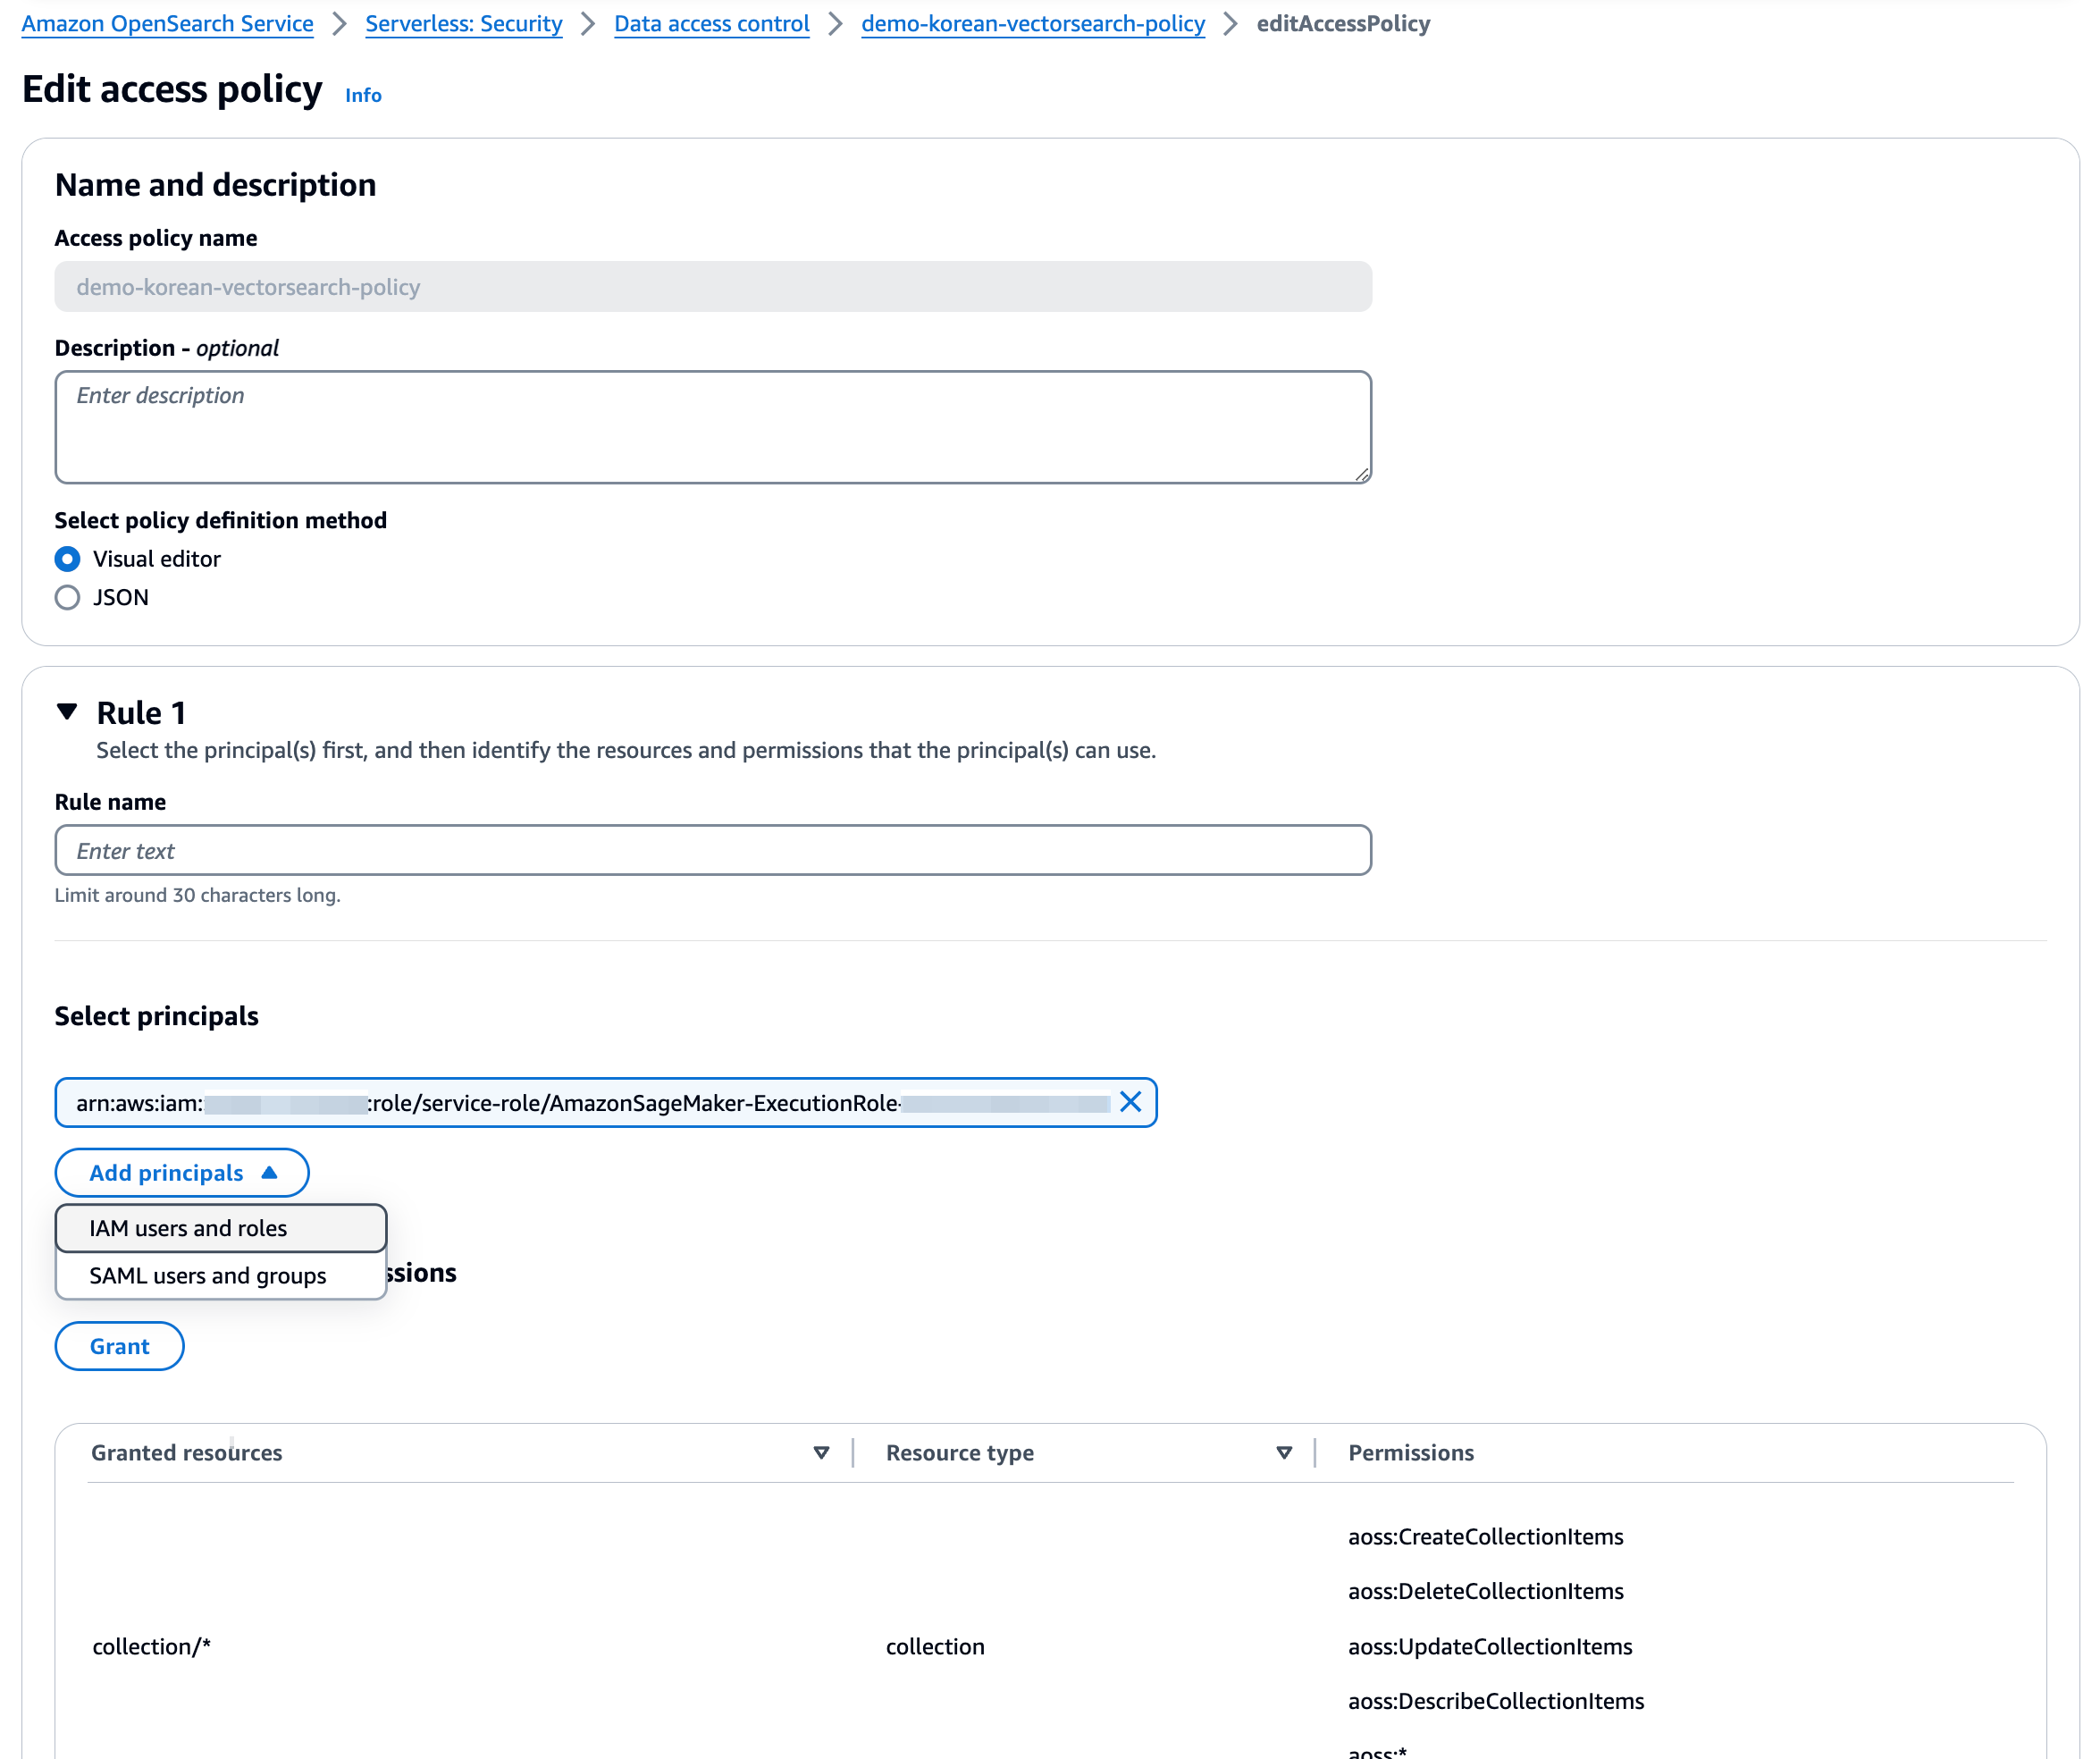

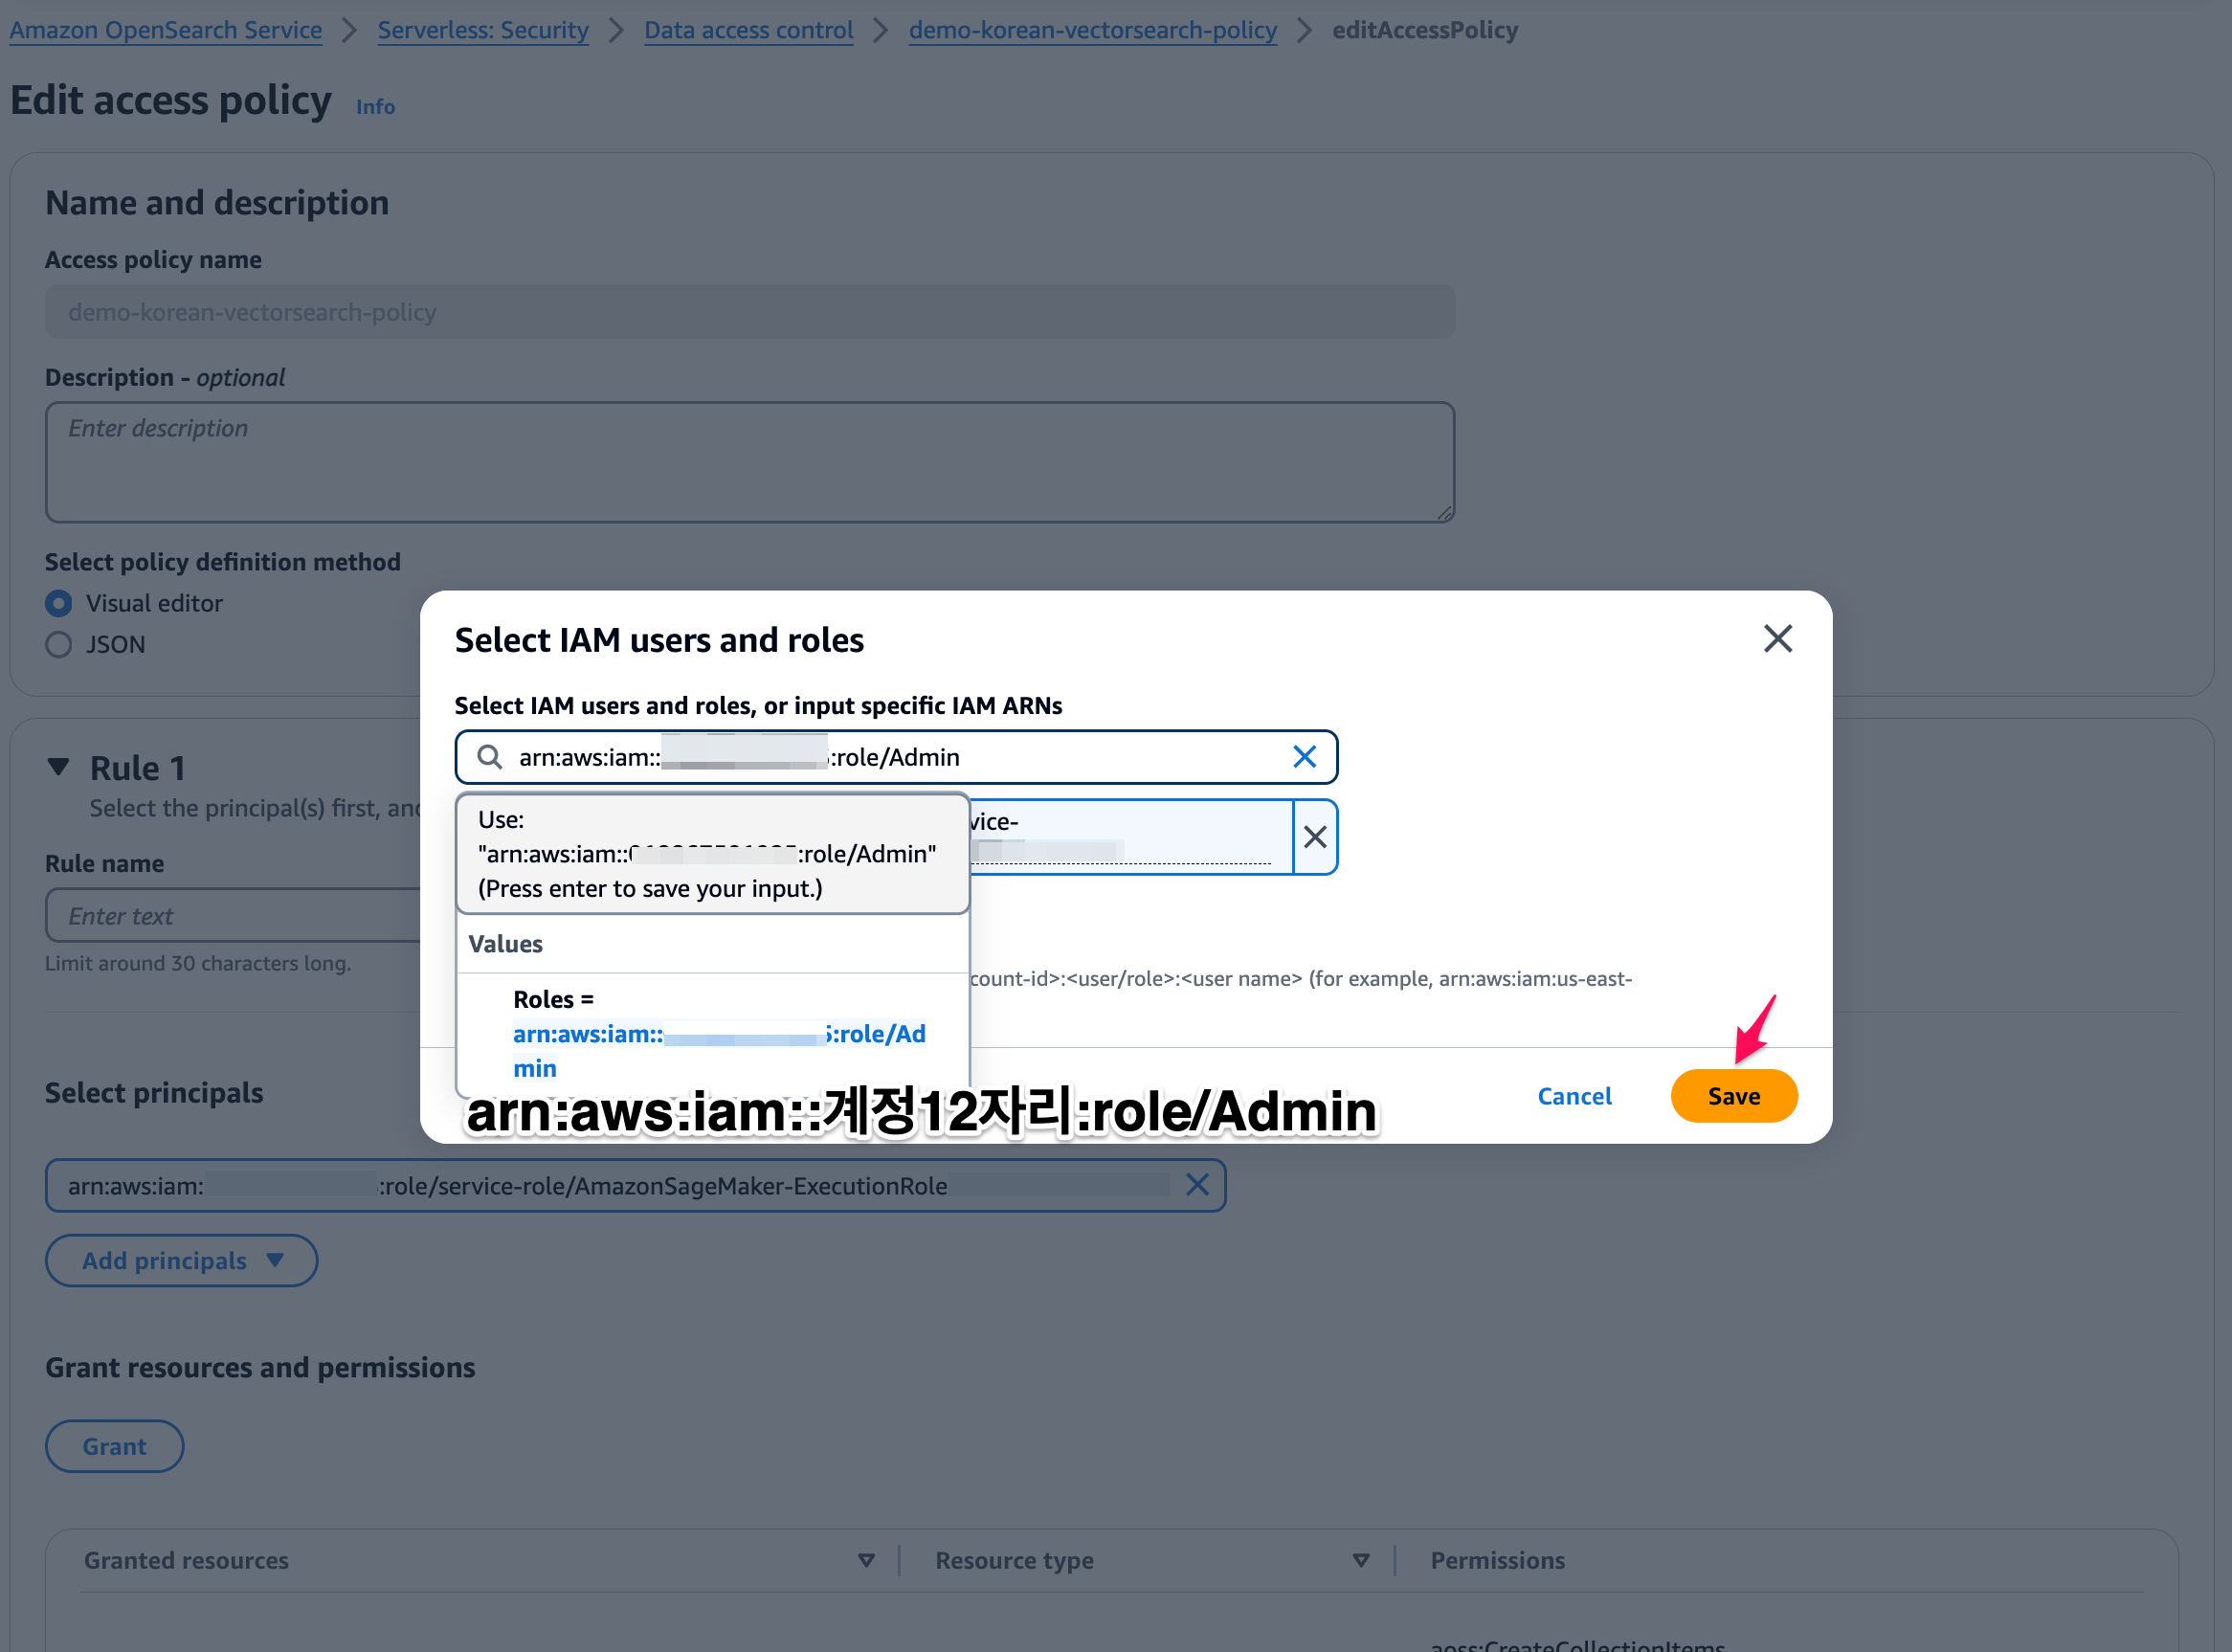

### Opensearch serverless collection에 문서 인덱싱
- **`genai-demo-index-v2`** 라는 인덱스에 문서를 인덱싱합니다.

In [ ]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

In [ ]:
client = boto3.client('opensearchserverless')
service = 'aoss'
region = 'us-east-1'
credentials = boto3.Session().get_credentials()
new_auth = AWSV4SignerAuth(credentials, region, service)

In [ ]:
%%time

docs_100 = [docs[x:x+100] for x in range(0, len(docs), 100)]

for doc in docs_100:
    docsearch = OpenSearchVectorSearch.from_documents(
        doc,
        llm_emb,
        opensearch_url=f"https://{vector_host}:443",
        http_auth=c,
        timeout=60,
        use_ssl=True,
        verify_certs=True,
        connection_class=RequestsHttpConnection,
        index_name="genai-demo-index-v2",
    )

## 인덱싱된 벡터 확인

In [ ]:
vector_db = OpenSearchVectorSearch(
    index_name="genai-demo-index-v2",
    opensearch_url=vector_host,
    embedding_function=llm_emb,
    http_auth=new_auth,
    is_aoss =False,
    space_type="l2"
)

In [ ]:
print(vector_db)

In [ ]:
retriever = docsearch.as_retriever(search_kwargs={"k": 10})

# 6.사용자 정의 가능한 옵션
이제 벡터 저장소가 준비되었으므로 질문을 시작할 수 있습니다.

Vector Store를 둘러싸서 LLM 입력을 받는 LangChain에서 제공하는 래퍼를 사용할 수 있습니다.
이 래퍼는 뒤에서 다음 단계를 수행합니다.
- 질문을 입력합니다.
- 질문 임베딩 생성
- 관련 문서 가져오기
- 프롬프트에 문서와 질문을 채워 넣습니다.
- 프롬프트로 모델을 호출하고 사람이 읽을 수 있는 방식으로 답변을 생성합니다.

위 시나리오에서는 질문에 대한 상황 인식 답변을 빠르고 쉽게 얻을 수 있는 방법을 탐색했습니다. 이제 문서를 가져오는 방법을 사용자 정의할 수 있는 [RetrievalQA](https://python.langchain.com/en/latest/modules/chains/index_examples/Vector_db_qa.html)의 도움으로 더 사용자 정의 가능한 옵션을 살펴보겠습니다. `chain_type` 매개변수를 사용하여 프롬프트에 추가해야 합니다. 또한 검색해야 하는 관련 문서 수를 제어하려면 아래 셀에서 'k' 매개변수를 변경하여 다른 출력을 확인하세요. 많은 시나리오에서 LLM이 답변을 생성하는 데 사용한 소스 문서가 무엇인지 알고 싶을 수 있습니다. LLM 프롬프트의 컨텍스트에 추가된 문서를 반환하는 `return_source_documents`를 사용하여 출력에서 ​​해당 문서를 가져올 수 있습니다. 'RetrievalQA'를 사용하면 모델에 특정한 사용자 정의 [프롬프트 템플릿](https://python.langchain.com/en/latest/modules/prompts/prompt_templates/getting_started.html)을 제공할 수도 있습니다.

참고: 이 예에서는 Amazon Bedrock에서 LLM으로 Anthropic Claude를 사용하고 있습니다. 이 특정 모델은 입력이 'Human:' 아래에 제공되고 모델이 'Assistant:' 다음에 출력을 생성하도록 요청되는 경우 가장 잘 수행됩니다. 아래 셀에는 LLM이 기본 상태를 유지하고 컨텍스트 외부에서 응답하지 않도록 프롬프트를 제어하는 ​​방법의 예가 나와 있습니다.

In [ ]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [ ]:
prompt_template = """
As a helpful news agent, please answer the question using only the context below.
If you don't know, say you don't know.
Cite the title of the articles you used to build your answer.

question: {question}

context: {context}
"""

prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])


def run_RetrievalQA(**kwargs):

    chain_types = ["stuff", "map_reduce", "refine"]

    assert "llm" in kwargs, "Check your llm"
    assert "query" in kwargs, "Check your query"
    assert "prompt" in kwargs, "Check your prompt"
    assert "vector_db" in kwargs, "Check your vector_db"
    assert kwargs.get("chain_type", "stuff") in chain_types, f'Check your chain_type, {chain_types}'

    qa = RetrievalQA.from_chain_type(
        llm=kwargs["llm"],
        chain_type=kwargs.get("chain_type", "stuff"),
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={
            "prompt": kwargs["prompt"],
            "verbose": kwargs.get("verbose", False),
        },
        verbose=kwargs.get("verbose", False)
    )


    return qa(kwargs["query"])

In [ ]:
query = "홈페이지 탈퇴하는방법 알려줘"

result = run_RetrievalQA(
    query=query,
    llm=llm_text,
    prompt=prompt,
    vector_db=vector_db,
    verbose=False,
    k=3
)


In [ ]:
query = '간편조회서비스는 회원가입해야하나요?'

result = run_RetrievalQA(
    query=query,
    llm=llm_text,
    prompt=prompt,
    vector_db=vector_db,
    verbose=False,
    k=3
)


In [ ]:
query = '아마존 공동인증서와 금융인증서 차이점이 무엇인가요?'

result = run_RetrievalQA(
    query=query,
    llm=llm_text,
    prompt=prompt,
    vector_db=vector_db,
    verbose=False,
    k=3
)